In [23]:
import os
import csv
import sys
from itertools import combinations
import networkx as nx
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc

In [6]:
path_to_data = "../../packages/Query data transformer/output_files/testInputTransformed.csv"

data_by_id = {}
data_by_author = {}

with open(path_to_data) as datafile:
    reader = csv.DictReader(datafile)
    # Each row contains one article author; thus each article will have as many rows as authors.
    for row in reader:
        year = int(row["year"])
        # Compile data only if year is in range 1999 to 2018.
        if year < 1999 or year > 2018:
            continue

        id_ = row["paper_id"]
        author_id = row["author_id"]
        author_name = row["author_name"]

        # Store data about each author for lookup by name.
        if author_id not in data_by_author:
            data_by_author[author_id] = {
                "author_name": [row["author_name"]],
                "last_known_affiliation_id": [row["last_known_affiliation_id"]],
                "doi": [row["doi"]] if row["doi"] != "" else [],
                "paper_id": [row["paper_id"]]
            }

        # If author is already in the dict, append additional affiliation and article info.
        else:
            for key in ["author_name", "paper_id",
                        "last_known_affiliation_id", "doi"]:
                if row[key] not in data_by_author[author_id][key]:
                    data_by_author[author_id][key].append(row[key])

        # Store data about each article for lookup by article ID.
        if id_ not in data_by_id:
            data_by_id[id_] = {
                "doi": row["doi"],
                "title": row["original_title"],
                "year": row["year"],
                "authors": [
                    {
                        "author_id": row["author_id"],
                        "name": row["author_name"],
                        "last_known_affiliation_id": [row["last_known_affiliation_id"]]
                    }
                ],
                "all_author_ids": [row["author_id"]]
            }
        # If article id already in dict, append additional author/affiliation data.
        else:
            if author_id in data_by_id[id_]["all_author_ids"]:
                for a in data_by_id[id_]["authors"]:
                    if a["author_id"] == author_id:
                        last_known = row["last_known_affiliation_id"]
                        if last_known not in a["last_known_affiliation_id"]:
                            a["last_known_affiliation_id"].append(last_known)

            else:
                new_author = {
                    "author_id": row["author_id"],
                    "name": row["author_name"],
                    "last_known_affiliation_id": [row["last_known_affiliation_id"]]
                }
                data_by_id[id_]["authors"].append(new_author)
                data_by_id[id_]["all_author_ids"].append(author_id)
                # -

In [11]:
# #### Check values for accuracy / highlight obvious issues

# + jupyter={"outputs_hidden": false}
#len(data_by_author)

# + jupyter={"outputs_hidden": false}
#list(data_by_author.keys())[0]

# + jupyter={"outputs_hidden": false}
data_by_author['109906890']

{'author_name': ['Kevin W. Boyack'],
 'last_known_affiliation_id': ['192454743'],
 'doi': ['10.1016/j.joi.2010.06.004',
  '10.1016/j.joi.2008.03.001',
  '10.1016/j.joi.2017.10.002',
  '10.1016/j.joi.2014.04.001',
  '10.1016/j.joi.2017.11.005'],
 'paper_id': ['2163354434',
  '2135710272',
  '2754386242',
  '1977805358',
  '2762538549']}

In [14]:
# Compare total number of rows to number of unique rows to roughly estimate authors per paper.

# + jupyter={"outputs_hidden": false}
ids = []

with open(path_to_data) as datafile:

    reader = csv.DictReader(datafile)
    for row in reader:
        id_ = row["paper_id"]
        ids.append(id_)
print(len(set(ids)), "total papers,", len(ids), "total authors")

961 total papers, 2368 total authors


In [18]:
# ### Building graph from author and article data

    # First, create the complete graph of all co-authorship.

    # + jupyter={"outputs_hidden": false}
    
G = nx.Graph()
for id_, data in data_by_id.items():
    authors = data["all_author_ids"]
    """
    Iterate over all combinations of authors per paper.
    For example if authors are 456, 789, and 123, iterate over 3 co-authorship combinations:
        456 789
        456 123
        789 123
    Add nodes and edges as needed for each combo.  
    """
    for i, j in combinations(authors, 2):
        year = data["year"]
        if G.has_edge(i, j):
            G[i][j]["weight"] += 1
            if id_ not in G[i][j]["articles"]:
                G[i][j]["articles"].append(id_)

            if year not in G[i][j]["years"]:
                G[i][j]["years"].append(year)
        else:
            G.add_edge(i, j, weight=1, articles=[id_], years=[data["year"]])

In [61]:
# Go back and iterate over all nodes created, adding affiliation/count/author data.
for author, data in G.nodes(data=True):
    data["papers"] = "<br>\n".join(data_by_author[author]["doi"])
    data["name"] = ", ".join(data_by_author[author]["author_name"])
    data["count"] = len(data_by_author[author]["paper_id"])

# + jupyter={"outputs_hidden": false}
len(G.edges)

# + jupyter={"outputs_hidden": false}
len(G.nodes)

# + jupyter={"outputs_hidden": false}
def filter_edge(n1, n2):
    """Check if weight is larger than 1."""
    return G[n1][n2]["weight"] > 1

def filter_node(n):
    """Filter out unconnected nodes."""
    return not nx.is_isolate(view, n)

view = nx.subgraph_view(G, filter_edge=filter_edge)
subview = nx.subgraph_view(view, filter_node=filter_node)

# + jupyter={"outputs_hidden": false}
len(subview.edges()), len(subview.nodes())

(263, 238)

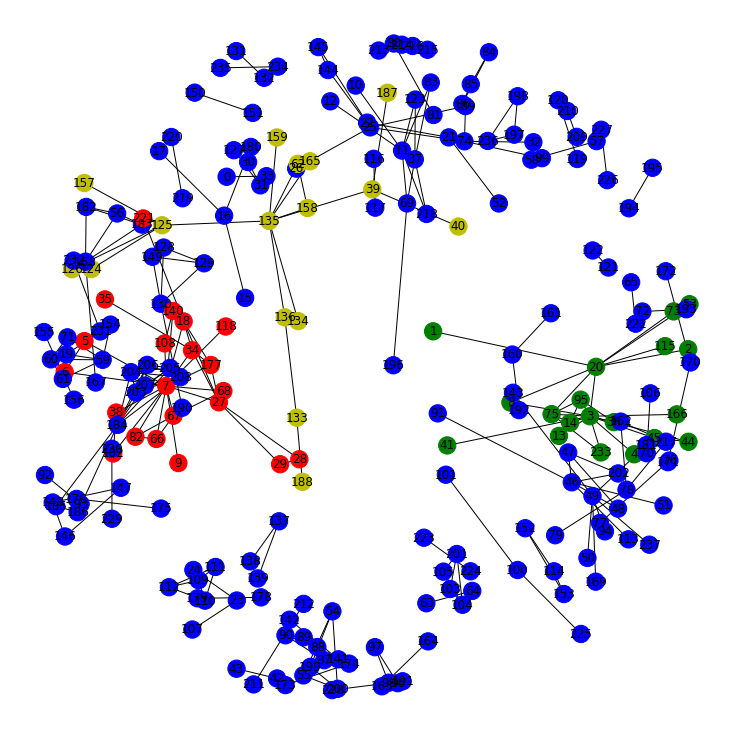

In [89]:
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx import relabel

subgraph = relabel.convert_node_labels_to_integers(subview)
c = list(greedy_modularity_communities(subgraph))
# show first 5 graphs
pos = nx.spring_layout(subgraph,k=5/np.sqrt(len(subgraph)))
colors = np.array(['b','r', 'g', 'y'])
label = np.zeros(len(subgraph),dtype=int)
label[list(map(int, c[0]))] = 1
label[list(map(int, c[1]))] = 2
label[list(map(int, c[2]))] = 3
plt.figure(figsize=(10,10))
nx.draw(subgraph, node_color=colors[label], with_labels=True, pos=pos)
plt.show()
plt.savefig('layout.pdf')  
plt.close()